DB: Analytical solution test 1
=====

Comparison of a solutions obtained via ``underworld2`` and analytic solutions provided by Dohrmann and Bochev (2004) (equations 48-50).

**References**

1. C. R. Dohrmann and P. B. Bochev, A stabilized finite element method for the Stokes problem based on polynomial pressure projections, IJNMF, 46(2), 183-201, 2004
http://onlinelibrary.wiley.com/doi/10.1002/fld.752/full



In [1]:
import underworld as uw
import math
from underworld import function as fn
import glucifer
import numpy as np

Setup mesh conditions
----

Change resolution parameters

In [2]:
meshX = 64
meshY = 64

Create mesh objects using the same parameters as Dohrmann and Bochev 2004

In [3]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dQ1"), 
                                 elementRes  = (meshX, meshY), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (1., 1.))

velocityField = uw.mesh.MeshVariable(mesh,2)
pressureField = uw.mesh.MeshVariable(mesh.subMesh,1)

**Setup analytic functions**

Functions consist of the body force, viscosity and velocity field inputs as well as the resulting pressure, stress and strain rate fields.


In [4]:
solA = fn.analytic.SolDB2d()

**Setup initial conditions**

Set initial velocity field to be the analytical solution, but set the initial pressure field to zero. The pressure field calculated by the Stokes solver will be compared to the analytical solution at the end.

Note that the boundary condition values are also set at this point.

In [5]:
vel=solA.fn_velocity
velocityField.data[:] = vel.evaluate(mesh.data)
pressureField.data[:] = 0.

**Plot the body force solution**


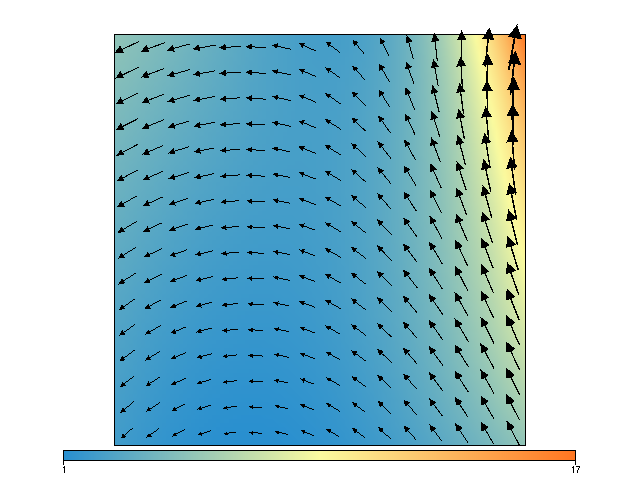

In [6]:
force = glucifer.Figure()
force.append( glucifer.objects.Surface(mesh, fn.math.dot(solA.fn_bodyforce,solA.fn_bodyforce) ) )
force.append( glucifer.objects.VectorArrows(mesh, solA.fn_bodyforce/10.) )
force.show()

**Plot the velocity field**


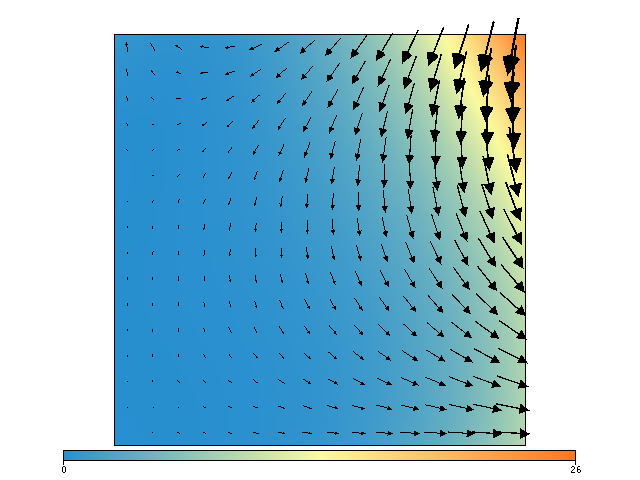

In [7]:
velFig = glucifer.Figure()
velFig.append( glucifer.objects.Surface(mesh, fn.math.dot(velocityField,velocityField)) )
velFig.append( glucifer.objects.VectorArrows(mesh, velocityField/10.) )
velFig.show()

**Set dirichlet boundary conditions on all walls**

In [8]:
IWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
JWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

BC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                       indexSetsPerDof = (IWalls+JWalls,IWalls+JWalls) )

Setup Stokes system
---

**Change here to test other solver options**

In [9]:
stokesSystem = uw.systems.Stokes(velocityField = velocityField,
                                 pressureField = pressureField,
                                 fn_viscosity  = solA.fn_viscosity,
                                 fn_bodyforce  = solA.fn_bodyforce,
                                 conditions    = [BC,])

solver = uw.systems.Solver( stokesSystem )

**Solve Stokes system**

This will solve for the pressure given the velocity, viscosity and body force.

In [10]:
solver.solve()

Compare ``underworld`` and analytical solutions
----

**Plot analytic solution to the pressure field**


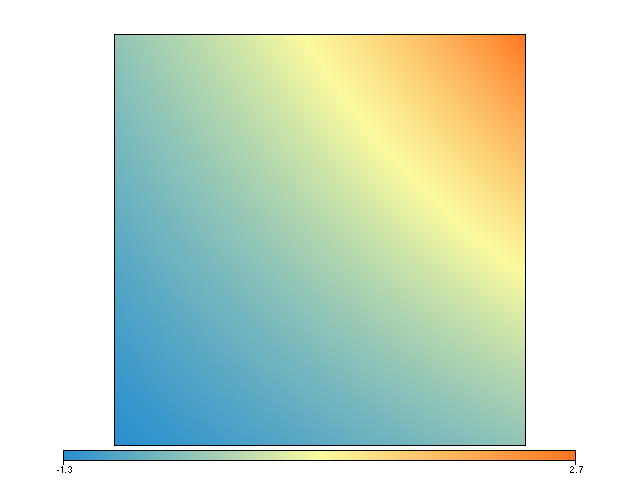

In [11]:
pA = glucifer.Figure()
pA.append( glucifer.objects.Surface(mesh, solA.fn_pressure ) )
pA.show()

**Plot difference between solved pressure field and analytic solution**


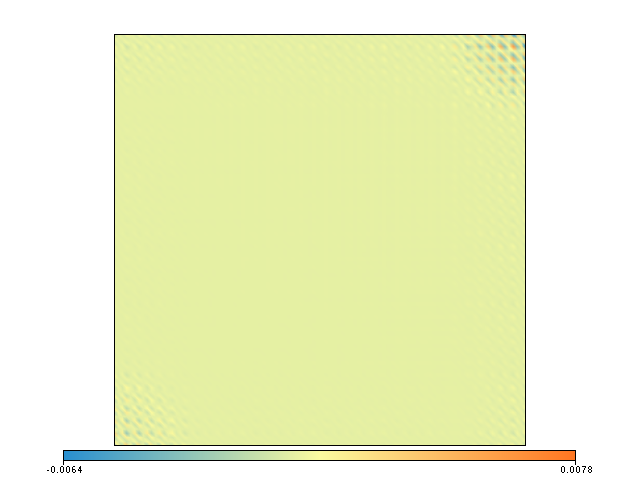

In [12]:
pDiff = glucifer.Figure()
pDiff.append( glucifer.objects.Surface(mesh, solA.fn_pressure-pressureField ) )
pDiff.show()

**Examine error across a single line**

Look at the error in the pressure field for $z=0.85$. In serial runs only.

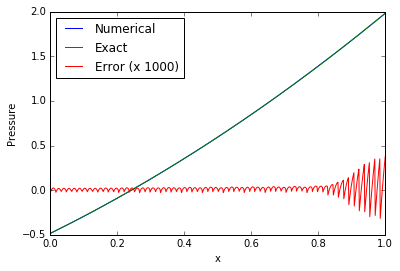

In [13]:
if(uw.nProcs()==1):
    uw.matplotlib_inline()
    import matplotlib.pyplot as pyplot
    import matplotlib.pylab as pylab
    pyplot.ion() # needed to ensure pure python jobs do now hang on show()
    N=801
    a=np.ndarray(shape=(N,2))
    a[:,0]=0.85*np.ones(N)
    a[:,1]=np.linspace(0,1,N)
    y=a[:,1]
    pex=solA.fn_pressure.evaluate_global(a)[:,0]
    pfd=pressureField.evaluate_global(a)[:,0]
    pyplot.plot(y,pfd,label='Numerical')
    pyplot.plot(y,pex,label='Exact')
    pyplot.plot(y,1000*(pfd-pex),label='Error (x 1000)')
    pyplot.xlabel('x')
    pyplot.ylabel('Pressure')
    pyplot.legend(loc=2)
    pyplot.savefig('Pressure_Error.png')

Global error measures
-----

Work out the global rms values for the velocity error (should be very low) and the pressure error.

In [14]:
v_err = uw.utils.Integral( fn   = fn.math.dot(solA.fn_velocity-velocityField, solA.fn_velocity-velocityField), 
                           mesh = mesh )
v_sol = uw.utils.Integral( fn   = fn.math.dot(solA.fn_velocity, solA.fn_velocity), 
                           mesh = mesh )
p_err = uw.utils.Integral( fn   = fn.math.dot(solA.fn_pressure-pressureField, solA.fn_pressure-pressureField), 
                           mesh = mesh )
p_sol = uw.utils.Integral( fn   = fn.math.dot(solA.fn_pressure, solA.fn_pressure), 
                           mesh = mesh )

area    = uw.utils.Integral( fn = 1., mesh = mesh )
totalArea = area.evaluate()[0]

rms_velocity_err = math.sqrt( v_err.evaluate()[0]/totalArea )
rms_velocity_rel = math.sqrt( v_err.evaluate()[0]/v_sol.evaluate()[0] )
rms_pressure_err = math.sqrt( p_err.evaluate()[0]/totalArea )
rms_pressure_rel = math.sqrt( p_err.evaluate()[0]/p_sol.evaluate()[0] )

In [15]:
if uw.rank()==0:
    print("Pressure error = {0:.6f}%; relative error = {1:.6f}%"
          .format(rms_pressure_err*100, rms_pressure_rel*100))
    print("Velocity error = {0:.6f}%; relative error = {1:.6f}%"
          .format(rms_velocity_err*100, rms_velocity_rel*100))

Pressure error = 0.026131%; relative error = 0.035121%
Velocity error = 0.000023%; relative error = 0.000013%


In [16]:
# errors on OSX @ commit 7b4a45bd5cc935e5553707719c4d37f3b53890eb
# petsc 3.6.3_4, open-mpi/1.10.2
rms_pressure_err_expected = 0.000261307467986
rms_pressure_rel_expected = 0.000351208475824
rms_velocity_err_expected = 2.29115120651e-07
rms_velocity_rel_expected = 1.29271006255e-07

In [17]:
tolerance = 1.01
if rms_pressure_err/rms_pressure_err_expected > tolerance: raise RuntimeError("Pressure absolute error outside tolerance")
if rms_pressure_rel/rms_pressure_rel_expected > tolerance: raise RuntimeError("Pressure relative error outside tolerance")
if rms_velocity_err/rms_velocity_err_expected > tolerance: raise RuntimeError("Velocity absolute error outside tolerance")
if rms_velocity_rel/rms_velocity_rel_expected > tolerance: raise RuntimeError("Velocity relative error outside tolerance")